In [20]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [45]:

# Define functions
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = int(parts[4])
            edges.append((res1, res2, weight))
    return edges

def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM"):
                res_number = int(line[22:26].strip())
                res_type = line[17:20].strip()
                chain = line[21].strip()
                pdb_data[res_number] = (res_type, chain)
    return pdb_data


def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
        'Mucins' :set(range(3880, 3999)).union(range(4419, 4538)).union(range(4538, 4657)).union( range(3999, 4139)).union(range(4279, 4419)).union(range(4139, 4279))
    #    'Chain M': range(3880, 3999),
    #    'Chain N': range(4419, 4538),
    #    'Chain O': range(4538, 4657),
    #    'Chain P': range(3999, 4139),
    #    'Chain Q': range(4279, 4419),
    #    'Chain R': range(4139, 4279)
    }
    
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

def generate_output_file(edges, pdb_data, output_file):
    with open(output_file, 'w') as file:
        for res1, res2, weight in edges:
            res1_info = pdb_data.get(res1, ("Unknown", "Unknown"))
            res2_info = pdb_data.get(res2, ("Unknown", "Unknown"))
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            file.write(f"Edge {res1}-{res2}-{weight}; {res1_info[0]}-{domain1}-{res1_info[1]} -> {res2_info[0]}-{domain2}-{res2_info[1]}\n")

def create_domain_residue_list(edges, pdb_data):
    domain_residues = defaultdict(set)
    for res1, res2, _ in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        if domain1:
            domain_residues[domain1].add(res1)
        if domain2:
            domain_residues[domain2].add(res2)
    return domain_residues

def plot_domain_weights(edge_files, pdb_data):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    

    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Plotting
    domains = list(normalized_weights.keys())
    means = [normalized_weights[d][0] for d in domains]
    stds = [normalized_weights[d][1] for d in domains]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))
    plt.bar(domains, means, yerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Domains')
    plt.ylabel('Normalized Weights')
    plt.title('Normalized Addition of Weights Corresponding to Each Domain (with Std Dev)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



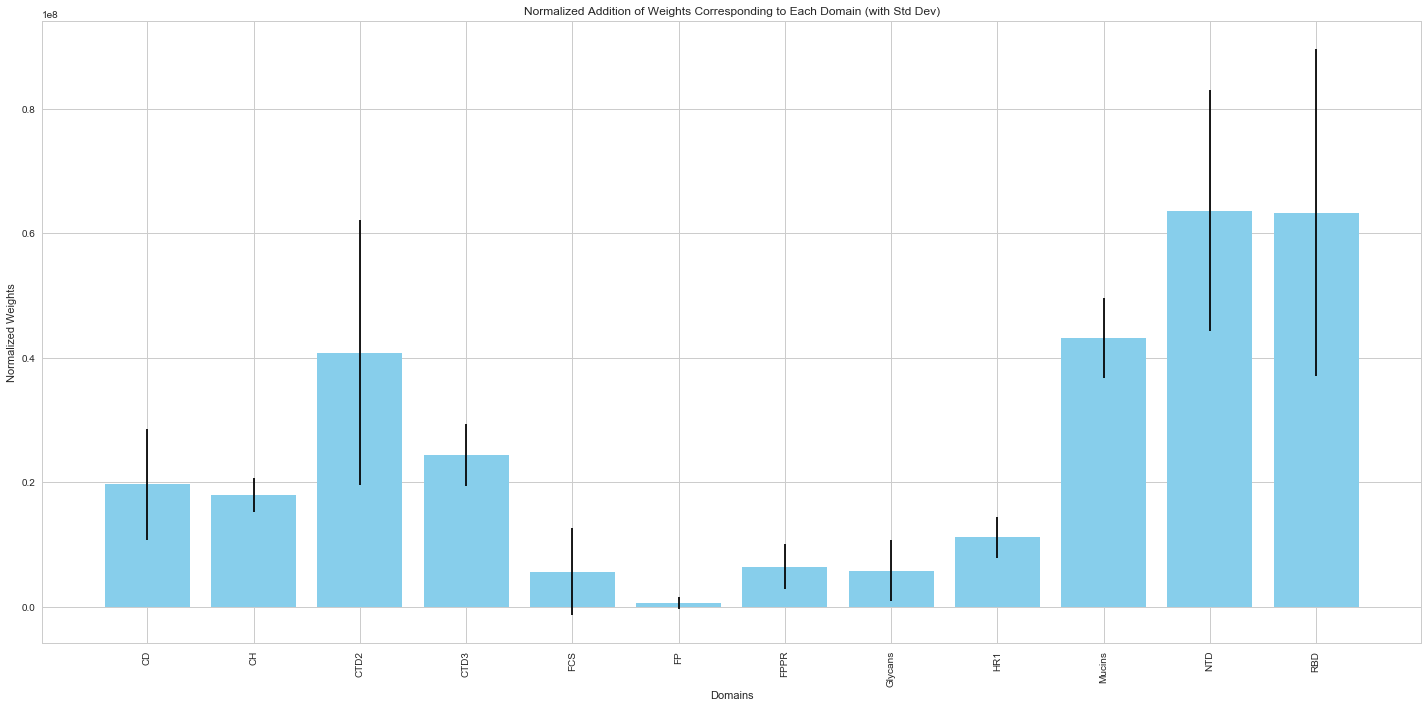

In [26]:
def plot_domain_weights(edge_files, pdb_data):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    
    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Plotting
    domains = list(normalized_weights.keys())
    means = [normalized_weights[d][0] for d in domains]
    stds = [normalized_weights[d][1] for d in domains]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))
    plt.bar(domains, means, yerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Domains')
    plt.ylabel('Normalized Weights')
    plt.title('Normalized Addition of Weights Corresponding to Each Domain (with Std Dev)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot domain weights with standard deviation
plot_domain_weights(edge_files, pdb_data)

For range of 3 chains:         'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),

In [25]:
# File paths
pdb_file_path = "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb"
edge_files = ["/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/egde_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep2/dist14/edge_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep3/dist14/edge_usage_1000.txt"]  # List all edge files here

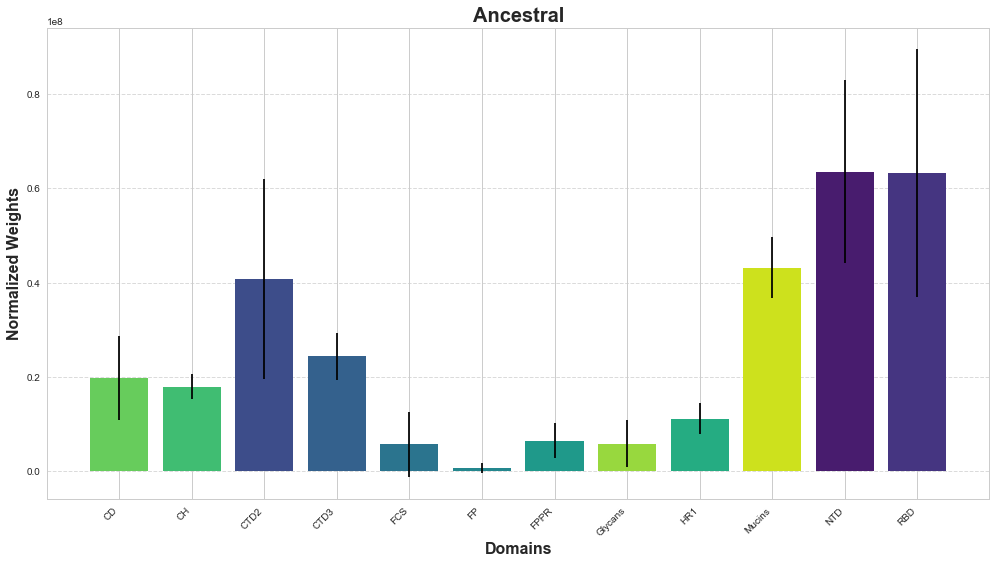

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def plot_domain_weights(edge_files, pdb_data, order=None):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    
    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Sort the domains according to the specified order or by total normalized weight
    if order:
        sorted_domains = order
    else:
        sorted_domains = sorted(normalized_weights.keys(), key=lambda x: normalized_weights[x][0], reverse=True)
    
    means = [normalized_weights[d][0] for d in sorted_domains]
    stds = [normalized_weights[d][1] for d in sorted_domains]
    
    # Set style
    sns.set(style="whitegrid")
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.bar(sorted_domains, means, yerr=stds, capsize=5, color=sns.color_palette('viridis', len(sorted_domains)))
    
    # Adding data labels
    #for bar, mean, std in zip(bars, means, stds):
    #    yval = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2, yval + std + 0.01, f'{mean:.2f}\n±{std:.2f}', 
    #             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    plt.xlabel('Domains', fontsize=16, fontweight='bold')
    plt.ylabel('Normalized Weights', fontsize=16, fontweight='bold')
    plt.title('Ancestral', fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
pdb_file_path = "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb"
edge_files = ["/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/egde_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep2/dist14/edge_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep3/dist14/edge_usage_1000.txt"]  # List all edge files here
# Define your desired order or use None for sorting by normalized weight
#desired_order = None  # Or set this to ['NTD', 'RBD', 'RBM', ...] as needed
desired_order = ['NTD', 'RBD', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 'HR1', 'CH', 'CD', 'Glycans', 'Mucins']

plot_domain_weights(edge_files, pdb_data, order=desired_order)


In [15]:
# Read PDB data
pdb_data = read_pdb(pdb_file_path)

In [16]:

# Generate output for each edge file
for edge_file in edge_files:
    output_file_path = edge_file.replace('.txt', '_info.txt')
    edges = read_edge_usage(edge_file)
    generate_output_file(edges, pdb_data, output_file_path)

In [18]:
# Plot domain weights with standard deviation
plot_domain_weights(edge_files, pdb_data)

NameError: name 'defaultdict' is not defined

In [16]:
def analyze_domain_interactions(target_domain, edges, pdb_data, domain_ranges):
    interaction_counts = defaultdict(int)
    interaction_weights = defaultdict(int)
    
    # Extract the residues in the target domain
    target_residues = {residue for residue, info in pdb_data.items() if get_domain(residue) == target_domain}
    
    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if res1 in target_residues:
            if domain2 and domain2 != target_domain:
                interaction_counts[domain2] += 1
                interaction_weights[domain2] += weight
        if res2 in target_residues:
            if domain1 and domain1 != target_domain:
                interaction_counts[domain1] += 1
                interaction_weights[domain1] += weight
    
    # Normalize weights
    total_weight = sum(interaction_weights.values())
    normalized_weights = {domain: weight / total_weight for domain, weight in interaction_weights.items()}
    
    return interaction_counts, normalized_weights

# Example usage:
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb")  # Your PDB data
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/egde_usage_1000.txt")  # Your edge data

#pdb_file_path = "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb"
#edge_files = ["/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/egde_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep2/dist14/edge_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep3/dist14/edge_usage_1000.txt"]  # List all edge files here


domain_ranges = {
    'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
    'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
    'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
    'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
    'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
    'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
    'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
    'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
    'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
    'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
    'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
    'Glycans': range(3389, 3880),
    'Mucins' :set(range(3880, 3999)).union(range(4419, 4538)).union(range(4538, 4657)).union( range(3999, 4139)).union(range(4279, 4419)).union(range(4139, 4279))
}

# Analyze interactions for 'Chain G'
interaction_counts, normalized_weights = analyze_domain_interactions('Mucins', edges, pdb_data, domain_ranges)

# Print results
print("Interaction Counts with Chain G:", interaction_counts)
print("Normalized Weights of Interactions with Chain G:", normalized_weights)


Interaction Counts with Chain G: defaultdict(<class 'int'>, {})
Normalized Weights of Interactions with Chain G: {}


In [17]:
import matplotlib.pyplot as plt

def plot_interaction_data(interaction_counts, normalized_weights, target_domain):
    # Plotting interaction counts
    domains = list(interaction_counts.keys())
    counts = [interaction_counts[domain] for domain in domains]
    weights = [normalized_weights[domain] for domain in domains]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for interaction counts
    bar_width = 0.4
    bar_positions = range(len(domains))
    bars1 = ax1.bar(bar_positions, counts, bar_width, alpha=0.7, label='Interaction Counts', color='skyblue')

    # Line plot for normalized weights
    ax2 = ax1.twinx()
    bars2 = ax2.plot(bar_positions, weights, color='orange', marker='o', linewidth=2, label='Normalized Weights')

    # Setting labels and titles
    ax1.set_xlabel('Domains')
    ax1.set_ylabel('Interaction Counts', color='skyblue')
    ax2.set_ylabel('Normalized Weights', color='orange')
    ax1.set_title(f'Interactions with {target_domain}')

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Customizing x-axis labels
    ax1.set_xticks(bar_positions)
    ax1.set_xticklabels(domains, rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage:
interaction_counts, normalized_weights = analyze_domain_interactions('Mucins', edges, pdb_data, domain_ranges)
plot_interaction_data(interaction_counts, normalized_weights, 'Mucins')


IndexError: list index out of range

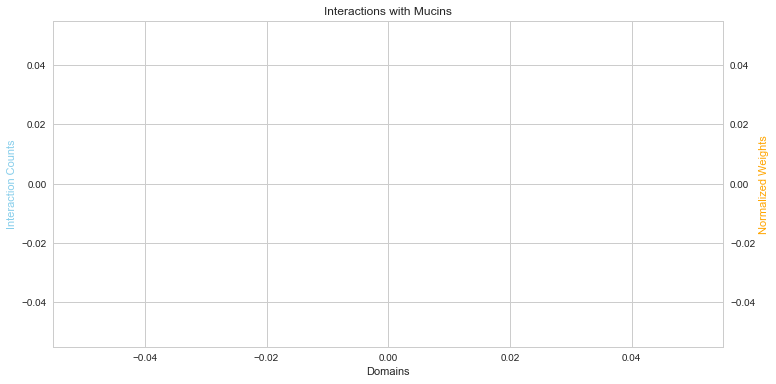

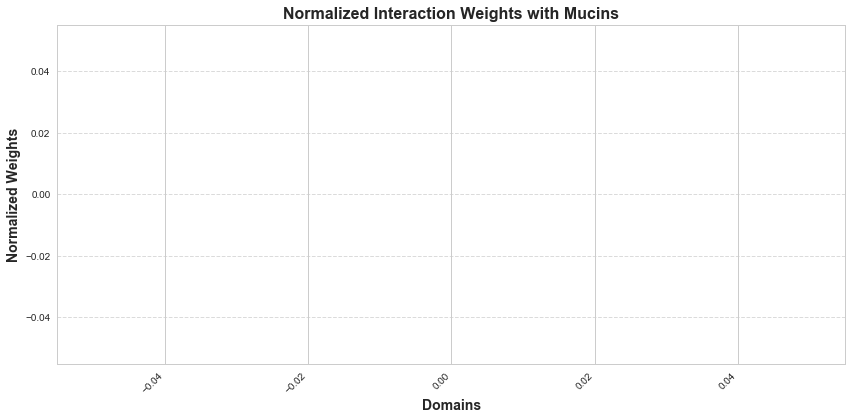

In [18]:
import matplotlib.pyplot as plt

def plot_normalized_interactions(normalized_weights, target_domain):
    # Extract domains and their corresponding normalized weights
    domains = list(normalized_weights.keys())
    weights = [normalized_weights[domain] for domain in domains]

    # Plotting normalized weights
    plt.figure(figsize=(12, 6))
    bars = plt.bar(domains, weights, color=sns.color_palette('viridis', len(domains)))

    # Adding data labels above the bars
    for bar, weight in zip(bars, weights):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{weight:.2f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Setting labels and titles
    plt.xlabel('Domains', fontsize=14, fontweight='bold')
    plt.ylabel('Normalized Weights', fontsize=14, fontweight='bold')
    plt.title(f'Normalized Interaction Weights with {target_domain}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
interaction_counts, normalized_weights = analyze_domain_interactions('Mucins', edges, pdb_data, domain_ranges)
plot_normalized_interactions(normalized_weights, 'Mucins')


In [55]:
from collections import defaultdict

def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(int))
    total_connections = defaultdict(int)
    total_weights = defaultdict(int)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += 1
            total_connections[domain1] += 1
            total_weights[domain1] += weight

    return domain_connections, total_connections, total_weights

def print_connectivity_report(domain_connections, total_connections, total_weights):
    for domain, connections in domain_connections.items():
        print(f"Domain: {domain}")
        for connected_domain, count in connections.items():
            connection_percentage = (count / total_connections[domain]) * 100
            weight_percentage = (total_weights[connected_domain] / total_weights[domain]) * 100
            print(f"  Connected to {connected_domain}: {count} connections ({connection_percentage:.2f}%), Weights: {weight_percentage:.2f}%")
        print()

# Example usage:
edges = read_edge_usage("egde_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, total_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
print_connectivity_report(domain_connections, total_connections, total_weights)


Domain: HR1
  Connected to NTD: 2 connections (22.22%), Weights: 114.86%
  Connected to CH: 3 connections (33.33%), Weights: 37.86%
  Connected to RBD: 2 connections (22.22%), Weights: 136.98%
  Connected to CD: 1 connections (11.11%), Weights: 22.89%
  Connected to CTD2: 1 connections (11.11%), Weights: 225.89%

Domain: FPPR
  Connected to FCS: 1 connections (16.67%), Weights: 97.01%
  Connected to HR1: 1 connections (16.67%), Weights: 131.96%
  Connected to CTD3: 3 connections (50.00%), Weights: 249.72%
  Connected to CTD2: 1 connections (16.67%), Weights: 298.10%

Domain: Mucins
  Connected to Glycans: 4 connections (50.00%), Weights: 81.48%
  Connected to CTD2: 2 connections (25.00%), Weights: 339.62%
  Connected to RBD: 2 connections (25.00%), Weights: 205.94%

Domain: CTD3
  Connected to CTD2: 3 connections (21.43%), Weights: 119.37%
  Connected to Glycans: 2 connections (14.29%), Weights: 28.64%
  Connected to FPPR: 3 connections (21.43%), Weights: 40.04%
  Connected to FCS: 6 c

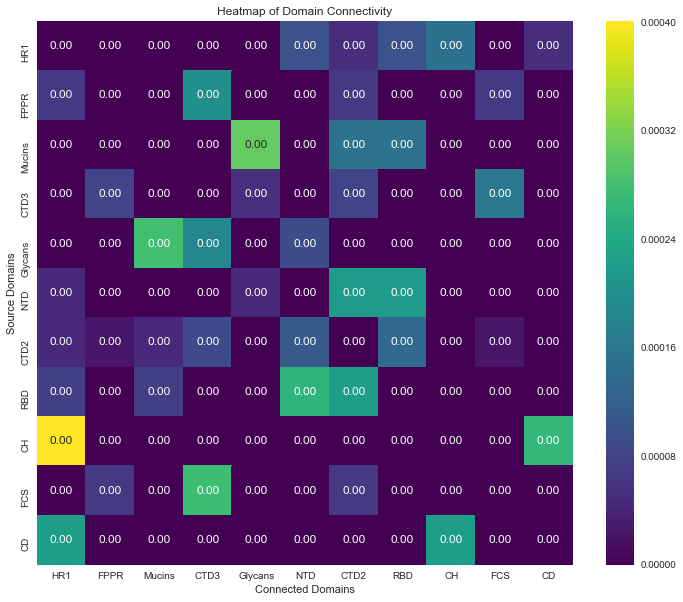

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_connectivity_heatmap(domain_connections, total_weights):
    # Prepare data for the heatmap
    domains = list(domain_connections.keys())
    data_matrix = np.zeros((len(domains), len(domains)))
    
    for i, domain in enumerate(domains):
        for j, connected_domain in enumerate(domains):
            if domain != connected_domain:
                weight = domain_connections[domain].get(connected_domain, 0)
                data_matrix[i, j] = weight / total_weights[domain] * 100  # Normalize weights to percentage
    
    # Plotting the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(data_matrix, annot=True, fmt=".2f", xticklabels=domains, yticklabels=domains, cmap='viridis')
    plt.title('Heatmap of Domain Connectivity')
    plt.xlabel('Connected Domains')
    plt.ylabel('Source Domains')
    plt.show()

# Example usage:
edges = read_edge_usage("egde_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, _, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_heatmap(domain_connections, total_weights)


In [57]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_connectivity_network(domain_connections, total_weights):
    G = nx.DiGraph()
    
    # Add nodes
    for domain in domain_connections:
        G.add_node(domain, weight=total_weights[domain])
    
    # Add edges
    for domain, connections in domain_connections.items():
        for connected_domain, weight in connections.items():
            if domain != connected_domain:
                G.add_edge(domain, connected_domain, weight=weight)
    
    # Draw the network
    pos = nx.spring_layout(G, k=0.5, seed=42)
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, 
            edge_color=edge_weights, edge_cmap=plt.cm.Blues, width=2.0)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm.set_array([])
    plt.colorbar(sm, label='Interaction Weights')
    plt.title('Network Graph of Domain Connectivity')
    plt.show()

# Example usage:
edges = read_edge_usage("egde_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, _, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


TypeError: fruchterman_reingold_layout() got an unexpected keyword argument 'seed'

In [61]:
from collections import defaultdict


/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/Users/carlac

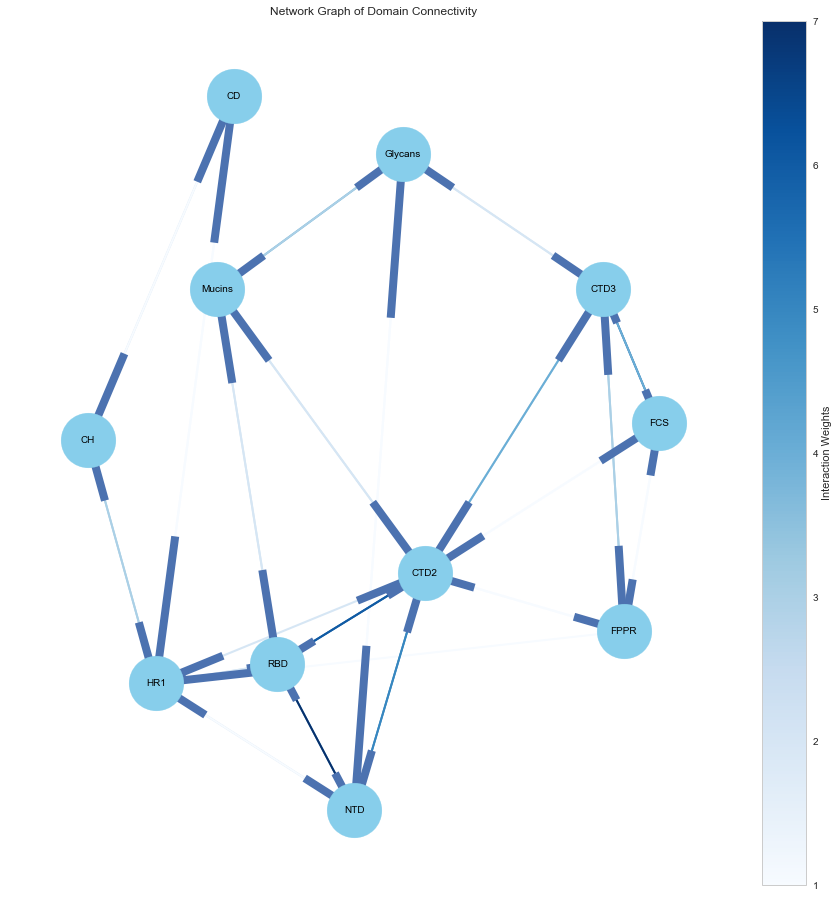

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_connectivity_network(domain_connections, total_weights):
    G = nx.DiGraph()
    
    # Add nodes
    for domain in domain_connections:
        G.add_node(domain, weight=total_weights[domain])
    
    # Add edges
    for domain, connections in domain_connections.items():
        for connected_domain, weight in connections.items():
            if domain != connected_domain:
                G.add_edge(domain, connected_domain, weight=weight)
    
    # Draw the network
    pos = nx.spring_layout(G, k=0.5)  # Removed 'seed=42' argument
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, 
            edge_color=edge_weights, edge_cmap=plt.cm.Blues, width=2.0)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm.set_array([])
    plt.colorbar(sm, label='Interaction Weights')
    plt.title('Network Graph of Domain Connectivity')
    plt.show()

# Example usage:
edges = read_edge_usage("egde_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, _, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  i

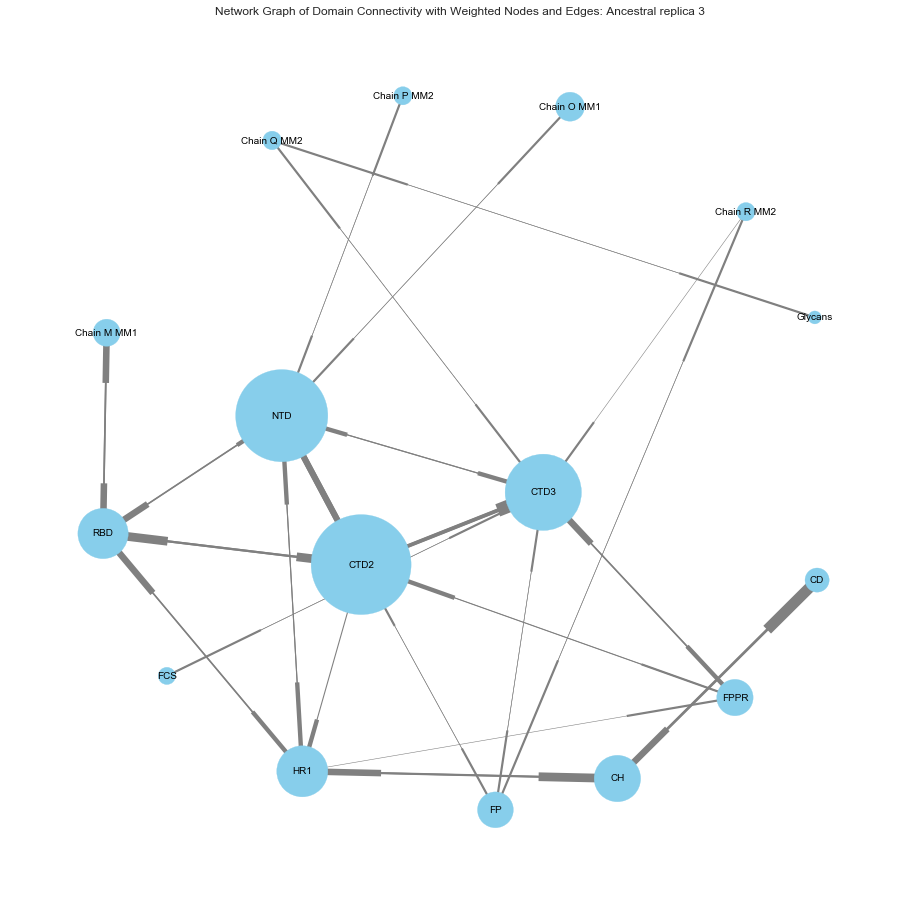

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges


def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6: 
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    # Handle unexpected values in residue number
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue
def get_domain(residue):
    # Define your domain ranges here
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
    #    'Mucins' :set(range(3880, 3999)).union(range(4419, 4538)).union(range(4538, 4657)).union( range(3999, 4139)).union(range(4279, 4419)).union(range(4139, 4279))
        'Chain M MM1': range(3880, 3999),
        'Chain N MM1': range(4419, 4538),
        'Chain O MM1': range(4538, 4657),
        'Chain P MM2': range(3999, 4139),
        'Chain Q MM2': range(4279, 4419),
        'Chain R MM2': range(4139, 4279)   
    }
    
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(int))
    total_connections = defaultdict(int)
    total_weights = defaultdict(int)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += 1
            total_connections[domain1] += 1
            total_weights[domain1] += weight

    return domain_connections, total_connections, total_weights

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.DiGraph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with weights
    for domain, connections in domain_connections.items():
        for connected_domain, weight in connections.items():
            if domain != connected_domain:
                G.add_edge(domain, connected_domain, weight=weight)
    
    # Draw the network without random_state for reproducibility
    pos = nx.spring_layout(G, k=0.5)  # Removed random_state argument
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [10000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by weight (normalize width)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, 
            edge_color='gray', width=edge_widths)
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges: Ancestral replica 3')
    plt.show()

# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep3/dist14/edge_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb")  # Your PDB data
domain_connections, _, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges


def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6: 
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    # Handle unexpected values in residue number
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue
def get_domain(residue):
    # Define your domain ranges here
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
    #    'Mucins' :set(range(3880, 3999)).union(range(4419, 4538)).union(range(4538, 4657)).union( range(3999, 4139)).union(range(4279, 4419)).union(range(4139, 4279))
        'Chain M MM1': range(3880, 3999),
        'Chain N MM1': range(4419, 4538),
        'Chain O MM1': range(4538, 4657),
        'Chain P MM2': range(3999, 4139),
        'Chain Q MM2': range(4279, 4419),
        'Chain R MM2': range(4139, 4279)   
    }
    
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(int))
    total_connections = defaultdict(int)
    total_weights = defaultdict(int)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += 1
            total_connections[domain1] += 1
            total_weights[domain1] += weight

    return domain_connections, total_connections, total_weights

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.DiGraph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with weights
    for domain, connections in domain_connections.items():
        for connected_domain, weight in connections.items():
            if domain != connected_domain:
                G.add_edge(domain, connected_domain, weight=weight)
    
    # Draw the network without random_state for reproducibility
    pos = nx.spring_layout(G, k=0.5)  # Removed random_state argument
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [10000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by weight (normalize width)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, 
            edge_color='gray', width=edge_widths)
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges: Delta replica 3')
    plt.show()

# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/delta/rep3/dist14/edge_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/delta/rep1/dist14/combined.pdb")  # Your PDB data
domain_connections, _, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


KeyError: 'FP'

/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  i

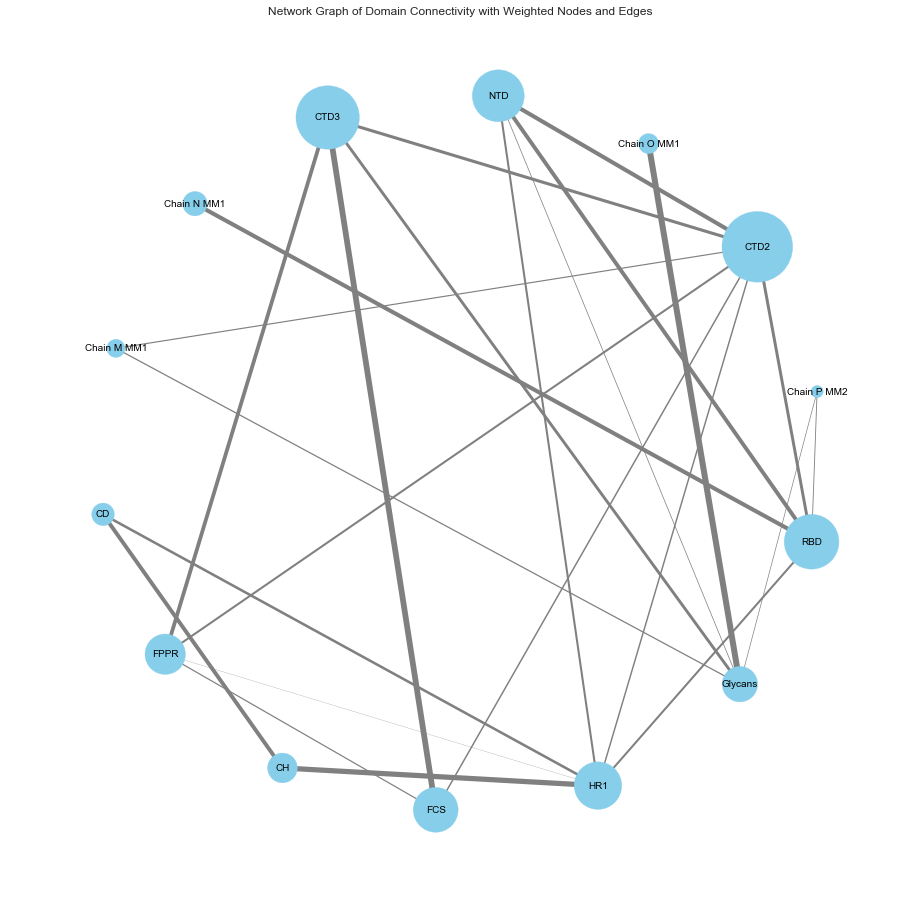

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
        'Chain M MM1': range(3880, 3999),
        'Chain N MM1': range(4419, 4538),
        'Chain O MM1': range(4538, 4657),
        'Chain P MM2': range(3999, 4139),
        'Chain Q MM2': range(4279, 4419),
        'Chain R MM2': range(4139, 4279)
    }
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Draw the network
    pos = nx.spring_layout(G, k=0.5)  # Adjust as necessary
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [5000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, 
            edge_color='gray', width=edge_widths)
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges')
    plt.show()

# Example usage:
edges = read_edge_usage("edge_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  i

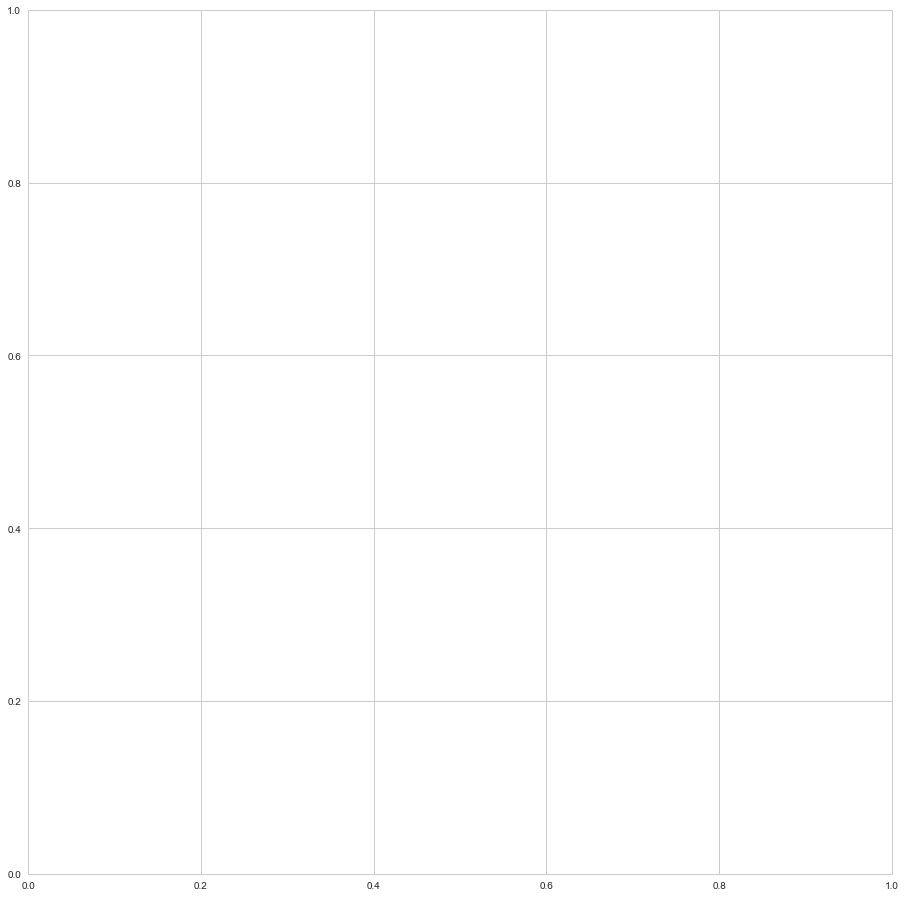

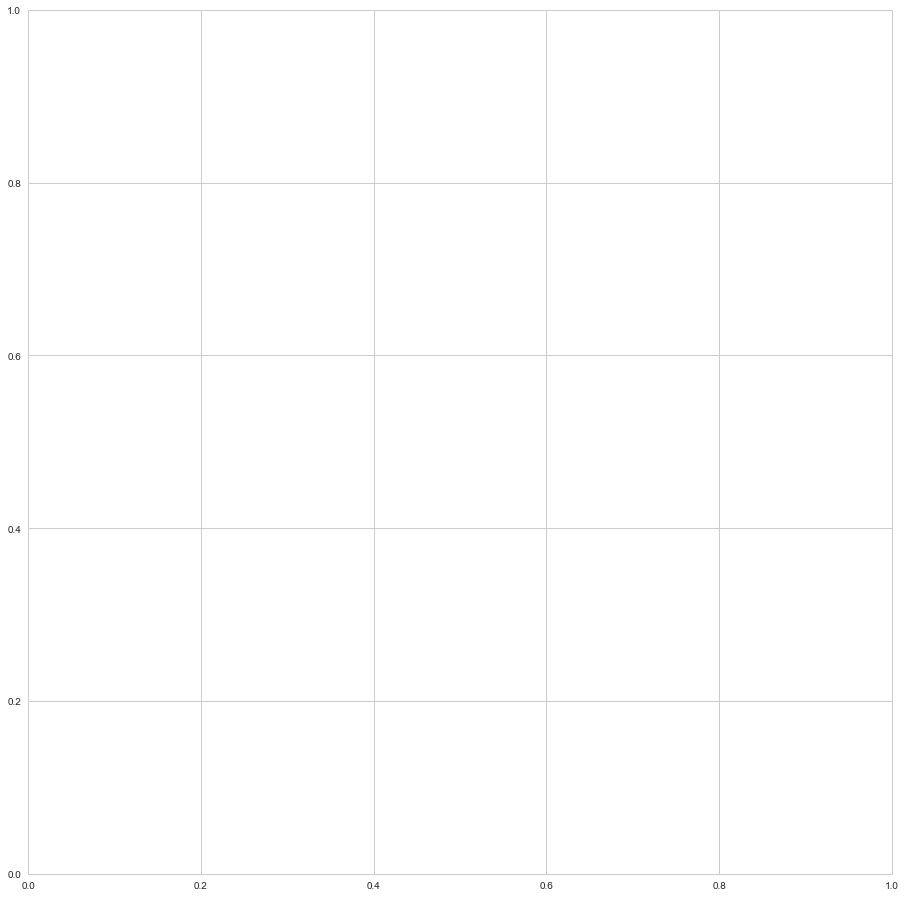

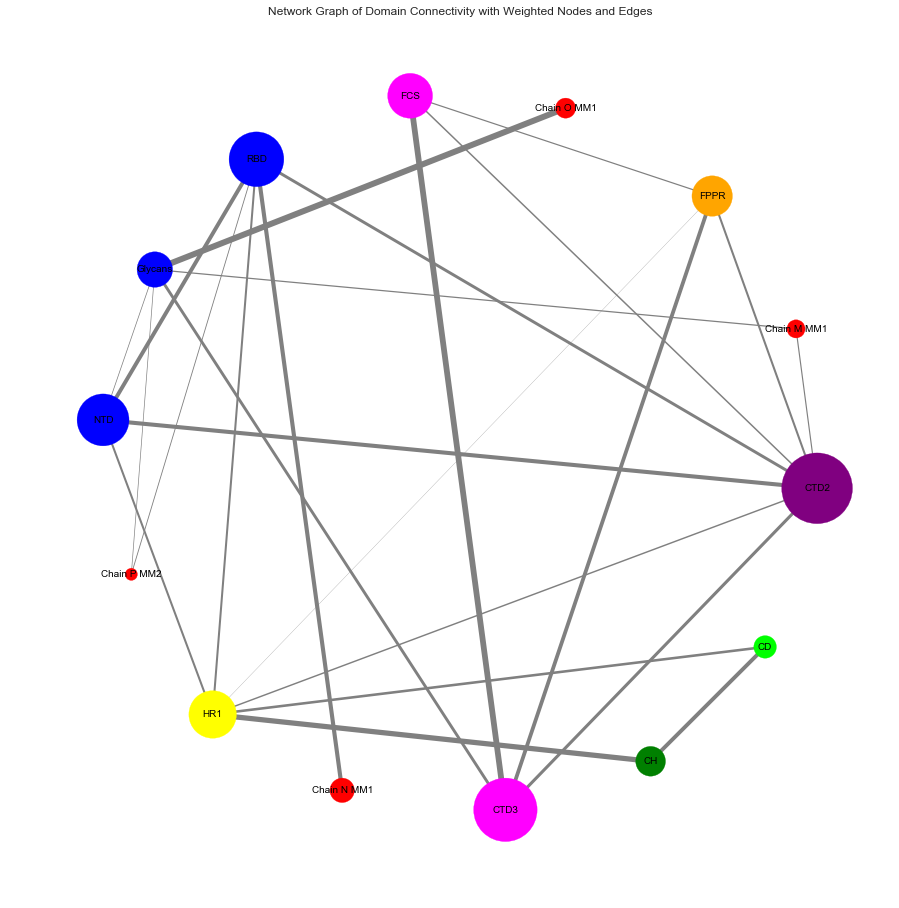

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),
        'RBD': set(range(331, 529)).union(range(1459, 1657)).union(range(2587, 2785)),
        'RBM': set(range(437, 509)).union(range(1565, 1637)).union(range(2693, 2765)),
        'CTD2': set(range(529, 590)).union(range(1657, 1718)).union(range(2785, 2846)),
        'CTD3': set(range(590, 676)).union(range(1691, 698)).union(range(1718, 1804)).union(range(1819, 1826)).union(range(2846, 2932)).union(range(2947, 2954)),
        'FCS': set(range(675, 691)).union(range(1803, 1819)).union(range(2931, 2947)),
        'FP': set(range(817, 835)).union(range(1945, 1963)).union(range(3073, 3091)),
        'FPPR': set(range(835, 856)).union(range(1963, 1984)).union(range(3091, 3112)),
        'HR1': set(range(910, 986)).union(range(2038, 2114)).union(range(3166, 3242)),
        'CH': set(range(985, 1035)).union(range(2113, 2163)).union(range(3241, 3291)),
        'CD': set(range(1035, 1069)).union(range(2163, 2197)).union(range(3291, 3325)),
        'Glycans': range(3389, 3880),
        'Chain M MM1': range(3880, 3999),
        'Chain N MM1': range(4419, 4538),
        'Chain O MM1': range(4538, 4657),
        'Chain P MM2': range(3999, 4139),
        'Chain Q MM2': range(4279, 4419),
        'Chain R MM2': range(4139, 4279)
    }
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Draw the network
    pos = nx.spring_layout(G, k=0.5)  # Adjust as necessary
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [5000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    # Define colors for each domain
    domain_colors = {
        'NTD': 'blue',
        'RBD': 'blue',
        'RBM': 'iceblue',
        'CTD2': 'purple',
        'CTD3': 'magenta',
        'FCS': 'magenta',
        'FP': 'pink',
        'FPPR': 'orange',
        'HR1': 'yellow',
        'CH': 'green',
        'CD': 'lime',
        'Glycans': 'blue',
        'Chain M MM1': 'red',
        'Chain N MM1': 'red',
        'Chain O MM1': 'red',
        'Chain P MM2': 'red',
        'Chain Q MM2': 'red',
        'Chain R MM2': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color='gray', width=edge_widths)
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges')
    plt.show()

# Example usage:
edges = read_edge_usage("edge_usage_1000.txt")  # Your edge data
pdb_data = read_pdb("combined.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)
